# Data Science Research Methods: Assignment 2

In [146]:
# Counts the words in the markdown cells 
import io
from IPython.nbformat import current

output = io.open('Assignment 2.ipynb', 'r', encoding='utf-8')
with output as f:
    nb = current.read(f, 'json')

word_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "markdown":
        # ignore hashtag 
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
print('number of words: ',word_count)
output.close()

number of words:  3958


In [145]:
# pyhton libraries 
from matplotlib import pyplot as plt
import matplotlib.mlab as mlab
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from scipy.stats import norm

# the 2 defined classificaiton problems 
classification_problem = {
    1: 'all_activity_recognition_task',
    2: 'intensity_estimation_task'
}

# the 12 different activities in chronological order
activity_class = {
    1: 'lying',
    2: 'sitting',
    3: 'standing',
    4: 'walking',
    5: 'running',
    6: 'cycling',
    7: 'Nordic\nwalking',
    12: 'ascending\nstairs',
    13: 'descending\nstairs',
    16: 'vacuum\ncleaning',
    17: 'ironing',
    24: 'rope\njumping'
}

# the 3 defined classes for the intensity estimation task 
met_class = {
    1: 'light',
    2: 'moderate',
    3: 'vigorous'
}

# the relevant columns the data exploration 
relevant_columns = [
    'timestamp', 'activityID', 'heart rate',
    'hand_acc_16g_x', 'hand_acc_16g_y', 'hand_acc_16g_z',
    'chest_acc_16g_x', 'chest_acc_16g_y', 'chest_acc_16g_z',
    'ankle_acc_16g_x', 'ankle_acc_16g_y', 'ankle_acc_16g_z'
    
]

# the columns used for the feature extractions 
feature_columns = [
    'heart rate',
    'hand_acc_16g_x', 'hand_acc_16g_y', 'hand_acc_16g_z',
    'chest_acc_16g_x', 'chest_acc_16g_z',
    'ankle_acc_16g_x', 'ankle_acc_16g_y', 'ankle_acc_16g_z'
]


# the 3 different classifiers used for the benchmark tests
current_clf = ['Naive Bayes','Decision Tree','kNN']

# the support vector machine (SVM) is added as a new classifier
extended_clf = current_clf + ['SVM']

# the 4 different score metrics 
metrics = ['Precision','Recall','F-measure','Accuracy']

# assigning the activities to the correpsonding met classes
light_met_classes = [1, 2, 3, 17]
moderate_met_classes = [16, 13, 4, 7, 6]
vigorous_met_classes = [12, 5, 24]

# the window and shift size for the segmentation
window_size = 512
shift_size = 100


def read_subjects(start,end):
    """
    Reads the subject files and concatenates them the into one panda dataset
    
    :param start: the number of the first subject file
    :param end: the number of the last subject file
    :return df: the panda dataframe 
    """
    
    df = pd.DataFrame()
    for i in range(start, end+1):
        temp_df = pd.read_csv('subject10' + str(i) + '.dat', header=None, delimiter=' ')
        df = pd.concat([df, temp_df])
    return df


def addheader(datasets):
    """
    Adds the corresponding headers to the raw dataset
    
    :param dataset: the raw dataset 
    :return dataset: the modified dataset
    """

    axes = ['x', 'y', 'z']
    imu_columns = ['temperature'] + \
                        ['acc_16g_' + i for i in axes] + \
                        ['acc_6g_' + i for i in axes] + \
                        ['gyroscope_' + i for i in axes] + \
                        ['magnometer_' + i for i in axes] + \
                        ['orientation_' + str(i) for i in range(4)]
    datasets.columns = ["timestamp", "activityID", "heart rate"] \
                       + ["hand_" + i for i in imu_columns] \
                       + ["chest_" + i for i in imu_columns] \
                       + ["ankle_" + i for i in imu_columns]

    return datasets


def get_mean_attribute(df_train,selected_attribute):
    """
    Gets the mean of an attribute for each activity
    
    :param df_train: the reduced dataset for EDA
    :param selected_attribute: the attribute for which the mean is calculated
    :return activity_names: a list of activitiy names and their met class
    :return attributes: a list of means for each activity 
    """
    
    mean_attribute = {}
    activity_names = []
    attributes = []

    # calculate the mean of the attribute and assign it to the corresponding activityID
    for id in df_train.activityID.unique():
        activity = df_train[df_train.activityID == id]
        mean_attribute[id] = activity[selected_attribute].mean()
        
    # create list of activity names   
    for attribute in sorted(mean_attribute.items(), key=lambda x: x[1]):
        attributes.append(attribute[1])
        id = attribute[0]
        activity_name = activity_class[id]

        if not '\n' in activity_name:
            activity_name += '\n'
        if id in light_met_classes:
            activity_names.append(activity_name + '\n' + met_class[1])
        elif id in moderate_met_classes:
            activity_names.append(activity_name + '\n' + met_class[2])
        elif id in vigorous_met_classes:
            activity_names.append(activity_name + '\n' + met_class[3])

    return activity_names, attributes

def calculate_attribute_parameter(attribute,mu):
    """
    Calculates from a given attribute such as the heart rate the needed parameters 
    for the hypothesis testing 
    
    :param attribute: the attribute for which the parameters are calculated
    :param: mu, the mean of the tested hypothesis
    :return n_attribute_moderate_met: the number of attributes from the moderate met class 
    :return mean_attribute_moderate_met: the mean of the attribute from the moderate met class
    :return std_attribute_moderate_met: the std of the attribute from the moderate met class
    :return z: the z-score used for the pvalue
    :return pvalue: the probability value for the hypothesis testing 
    """
    
    attribute_moderate_met = df_test.query('activityID == [16, 13, 4, 7, 6]')[attribute]
    n_attribute_moderate_met = attribute_moderate_met.count()
    mean_attribute_moderate_met = attribute_moderate_met.mean()
    std_attribute_moderate_met = attribute_moderate_met.std()
    z = (mean_attribute_moderate_met - mu) / (std_attribute_moderate_met / np.sqrt(n_attribute_moderate_met))
    # Cumulative distribution function
    pvalue = 1 - norm.cdf(z)
    return n_attribute_moderate_met, mean_attribute_moderate_met ,std_attribute_moderate_met,z,pvalue

def sliding_window(class_type, dataframe):
    """
    Divides the time-series into a sequence of windows in order to extract the features
    
    :param class_type: the classificaiton problem 
    :param dataframe: the dataframe which should be divided
    :return window_class_mappings: a list of mappings between a window and its corresponding class 
    """
    
    activity_ids = dataframe.activityID.unique()
    window_class_mappings = []
    for id in activity_ids:
        windows = []
        activity = dataframe[dataframe.activityID == id]
        number_rows = activity.timestamp.count()
        activity = activity[feature_columns]
        current_position = 0
        # repeat until the last row is reached
        while current_position < number_rows:
            window = activity.iloc[current_position:current_position + window_size]
            # create a numpy matrix 
            windows.append(window.as_matrix())
            current_position += shift_size
        define_classes(class_type, id, windows, window_class_mappings)
    return window_class_mappings


def define_classes(classification, id, windows, window_class_mappings):
    """
    Defines the mapping between a window and its coressponding class regarding the classification problem
    
    :param classification: the classification problem defines the coressponding class 
    :param id: the activityID
    :param windows: the window which contains 512 samples
    :param window_class_mappings: a mapping between a window and its corresponding class
    
    """
    
    if classification == classification_problem[1]:
        window_class_mappings.append((id, windows))
       
    elif classification == classification_problem[2]:
        if id in light_met_classes:
            window_class_mappings.append((met_class[1], windows))

        elif id in moderate_met_classes:
            window_class_mappings.append((met_class[2], windows))

        elif id in vigorous_met_classes:
            window_class_mappings.append((met_class[3], windows))
    


def feature_extraction(windows_class_list):
    """
    Divides the windows_class_list into a list of features and its corresponding list target
    
    :param windows_class_list: a list of mappings between a window and its corresponding class
    :return mean_features: a list of mean features
    :return targets: a list of targets 
    """
    
    mean_features = []
    targets = []

    for windows_class_map in windows_class_list:
        target = windows_class_map[0]
        windows = windows_class_map[1]
        for window in windows:
            mean_features.append(window.mean(0))
            targets.append(target)

    return mean_features, targets


def split_train_test(features, targets):
    """
    Splits the features into different lists for the supervised learning procedure 
    
    :param features: a list of features
    :param targets: a list of targets 
    :return feature_train_set, feature_test_set, target_train_set, target_test_set 
    """
    
    return train_test_split(features, targets, test_size=0.3, random_state=10)


def apply_naive_bayes_clf(features_train, target_train, features_test):
    """
    Trains and tests the naive bayes classfier 
    
    :param features_train: a list of features for training the classifier
    :param target_train: a list of targets for training the classifer 
    :param features_test: a list of features to test the classifier
    :return target_test: a list of predicted targets
    """
    
    nb_clf = GaussianNB()
    nb_clf.fit(features_train, target_train)
    return nb_clf.predict(features_test)


def apply_kNN_clf(features_train, target_train, features_test):
    """
    Trains and tests the k-nearest neighbor classfier 
    
    :param features_train: a list of features for training the classifier
    :param target_train: a list of targets for training the classifer 
    :param features_test: a list of features to test the classifier
    :return target_test: a list of predicted targets
    """
    
    clf = KNeighborsClassifier(n_neighbors=7)
    clf.fit(features_train, target_train)
    return clf.predict(features_test)


def apply_decision_tree_clf(features_train, target_train, features_test):
    """
    Trains and tests the decision tree classifier 
    
    :param features_train: a list of features for training the classifier
    :param target_train: a list of targets for training the classifer 
    :param features_test: a list of features to test the classifier
    :return target_test: a list of predicted targets
    """
    
    clf = DecisionTreeClassifier(random_state=0)
    clf.fit(features_train, target_train)
    return clf.predict(features_test)

def apply_svm_clf(features_train, target_train, features_test):
    """
    Train and test the support vector machine 
    
    :param features_train: a list of features for training the classifier
    :param target_train: a list of targets for training the classifer 
    :param features_test: a list of features to test the classifier
    :return target_test: a list of predicted targets
    """
    
    clf = svm.SVC()
    clf.fit(features_train, target_train)
    return clf.predict(features_test)

def calculate_scores(target_test, target_pred):
    """
    Calculates the precision, recall and f-measure from a given test and predicted target
    :param target_test: the ground truth 
    :param target_pred: the predicted values 
    :return scores: a list of the predcited scores 
    """
    a = accuracy_score(target_test, target_pred)
    p, r, f, none = precision_recall_fscore_support(target_test, target_pred, average='macro')
    scores = []
    scores.extend([p, r, f, a])
    return scores

def get_scores_from_all_clf(features_train,target_train,features_test):
    """
    Trains and tests 4 different classifiers and gets their precision, recall, f-measure and accuarcy scores
    
    :param features_train: a list of features for training the classifier
    :param target_train: a list of targets for training the classifer 
    :param features_test: a list of features to test the classifier
    :return a panda dataframe which contains a table of all the scores 
    """
    
     # naive bayes
    target_pred = apply_naive_bayes_clf(features_train,target_train,features_test)
    nb_scores = ['%.4f' % i for i in calculate_scores(target_test,target_pred)]

    # decision tree
    target_pred = apply_decision_tree_clf(features_train,target_train,features_test)
    dt_scores = ['%.4f' % i for i in calculate_scores(target_test,target_pred)]

    # k-nearest neighbor 
    target_pred = apply_kNN_clf(features_train,target_train,features_test)
    knn_scores = ['%.4f' % i for i in calculate_scores(target_test,target_pred)]
    
    # support vector machines 
    target_pred = apply_svm_clf(features_train,target_train,features_test)
    svm_scores = ['%.4f' % i for i in calculate_scores(target_test,target_pred)]
    
    # concatenate the lists vertically 
    scores = np.vstack((nb_scores,dt_scores,knn_scores,svm_scores))
    return pd.DataFrame(scores,index=extended_clf,columns=metrics)

def get_current_scores(task):
    """
    Depending on the classification problem, returns the scores of all the classifiers 
    from the current benchmark
    
    :param task: the classification problem
    :return a panda dataframe which contains all the scores
    """

    if task == classification_problem[1]:
        nb_scores = [0.9419, 0.9519, 0.9469, 0.9438]
        dt_scores = [0.9554, 0.9563, 0.9558, 0.9546]
        knn_scores = [0.9946, 0.9937, 0.9942, 0.9925]    

    if task == classification_problem[2]:
        nb_scores = [0.9157, 0.8553, 0.8845, 0.9310]
        dt_scores = [0.9796, 0.9783, 0.9789, 0.9823]
        knn_scores = [0.9985, 0.9987, 0.9986, 0.9982]

    scores = np.vstack([nb_scores,dt_scores,knn_scores])  
    return pd.DataFrame(scores,index=current_clf,columns=metrics)
    

def count_activity_amount(target):
    """
    Counts for each activity the duration carried out by all subjects
    :param target: either the test or the predicted target
    :return a list of all activity names and a a list their corresponding duration 
    """
    
    activity_duration_mappings = {}
    activity_names = []
    durations = []
    
    for id,seconds in Counter(target).items():
        activity_duration_mappings[id] = seconds 

    for activity,duration in activity_duration_mappings.items():
        activity_names.append(activity_class[activity])
        durations.append(duration)
    
    return activity_names, durations


def plot_attribute_of_activities(activity_names,attribute,y_title,title):
    """
    Plots the attribute of all the activities such as the mean heart rate
    
    :param activity_names: all the activity names
    :param attribute: the given attribute  
    :param y_title: the title of the y axis
    :param title: the title of the figure
    """
    
    sns.set(style="white", context="talk")    
    num_attribute = np.arange(len(attribute))
    fig, ax = plt.subplots(figsize=(15, 4))
    sns.barplot(num_attribute,attribute, palette="RdBu_r")
    plt.title(title)
    plt.xticks(num_attribute,activity_names)
    plt.ylabel(y_title)
    plt.show()
    
    
def plot_activity_bar(activity_names,predicted_durations,expected_durations):
    """
    Plots two bar charts in one figure, the exptected and predicted durations  
    :param activity_names: all the activity names 
    :param predicted_durations: the predicted activity durations
    :param expected_durations: the expected activity durations
    """
    
    fig, ax = plt.subplots(figsize=(15, 6))
    y_pos = np.arange(len(expected_durations))
    width = 0.35 # the width of the bars
     
    rects1 = ax.bar(y_pos,predicted_durations,width)
    rects2 = ax.bar(y_pos + width,expected_durations,width)

    ax.set_xticks(y_pos + width / 2)
    ax.legend((rects1[0], rects2[0]), ('predicted duration', 'expected duration'))
    ax.set_ylabel('activity performed in seconds')
    ax.set_title('Activities')
    ax.set_xticklabels(activity_names)
    plt.show()
    

# Table of Contents 

The report is structured as follows:
1. Introduction
- Preprocessing 
- Exploratory Data Analysis
- Hypothesis Testing 
- Models
    - Segmentation 
    - Feature Extraction 
    - Classifiers
- Results
- Duration prediction
- Conclusion
- Bibliography 


# 1. Introduction

### PAMAP2 
The PAMAP2 Physical Activity Monitoring dataset contains data of 18 different physical activities, performed by 9 subjects wearing 3 inertial measurement units (IMUs) and a heart rate monitor. 

There are two published conference papers describing the dataset while the first one, a more detailed version, is taken as a reference (Reiss and Stricker, 2012). 

###  Labelled data.
The PAMAP2 contains labelled data and thus for every row an activity id is available. The activity id is referred as the ground truth and allows to know the corresponding class of each training sample. This has the benefit of being able to apply supervised machine learning algorithms which is explained in more details in section 5. Models.  
 

## Goal
The goal of this assignment is to develop hardware and/or software which can determine the amount and type of
physical activity carried out by an individual. In machine learning the problem of determining the type of a data, is known as classification. The PAMAP2 was created for physical activity monitoring with the motivation to provide a standardized platform for benchmarking tests with defined classification problems. Therefore, the same classification problems are used as in the benchmark tests in order to have a realistic comparison. 

### Classification problems 
While there are 18 different physical activities, the six optional activities are not used by Reiss and Stricker and are left for future work . Therefore, the following 12 activities are selected and shown in the order they are performed by the subjects:

1. lying
- sitting
- standing 
- ironing
- vacuum cleaning
- ascending stairs
- descending stairs
- walking
- Nordic walking
- cycling
- running
- rope jumping


There are several ways how the activities can be grouped together by a particular criterion as shown in the next chapters. 


#### 1. All activity recognition task
This classification problem defines 12 classes, corresponding to the 12 activities and therefore each activity has its own class.  

#### 2. Intensity estimation task
For this classification problem three classes are defined: activities of light, moderate and vigorous effort. These are based on the the Metabolic Equivalent of Task (MET) which is a physiological measure expressing the energy cost of physical activities. 

The activities are assigned to the following classes: 
- light effort (< 3.0 MET): lying, sitting, standing and ironing 
- moderate effort (3.0 - 6.0 MET): vacuum cleaning, descending stairs, normal walking, Nordic walking and cycling 
- vigorous effort (> 6.0 MET): ascending stairs, running and rope jumping 


Reiss and Stricker define two more classification problems, once with five classes and once with six classes. Those are not taken into consideration.  
 


# 2. Preprocessing
During the pre-processing step the raw data is prepared for data mining by cleaning it and handling missing values appropriately. The data from all the 9 subjects is read into a pandas dataframe. Subsequently, the missing headers are added.  

In [112]:
df = read_subjects(1,9)
addheader(df).head()

,timestamp,activityID,heart rate,hand_temperature,hand_acc_16g_x,hand_acc_16g_y,hand_acc_16g_z,hand_acc_6g_x,hand_acc_6g_y,hand_acc_6g_z,...,ankle_gyroscope_x,ankle_gyroscope_y,ankle_gyroscope_z,ankle_magnometer_x,ankle_magnometer_y,ankle_magnometer_z,ankle_orientation_0,ankle_orientation_1,ankle_orientation_2,ankle_orientation_3
0,8.38,0,104.0,30.0,2.37223,8.60074,3.51048,2.43954,8.76165,3.35465,...,0.008300,0.009250,-0.017580,-61.1888,-38.9599,-58.1438,1.0,0.0,0.0,0.0
1,8.39,0,NaN,30.0,2.18837,8.56560,3.66179,2.39494,8.55081,3.64207,...,-0.006577,-0.004638,0.000368,-59.8479,-38.8919,-58.5253,1.0,0.0,0.0,0.0
2,8.40,0,NaN,30.0,2.37357,8.60107,3.54898,2.30514,8.53644,3.73280,...,0.003014,0.000148,0.022495,-60.7361,-39.4138,-58.3999,1.0,0.0,0.0,0.0
3,8.41,0,NaN,30.0,2.07473,8.52853,3.66021,2.33528,8.53622,3.73277,...,0.003175,-0.020301,0.011275,-60.4091,-38.7635,-58.3956,1.0,0.0,0.0,0.0
4,8.42,0,NaN,30.0,2.22936,8.83122,3.70000,2.23055,8.59741,3.76295,...,0.012698,-0.014303,-0.002823,-61.5199,-39.3879,-58.2694,1.0,0.0,0.0,0.0


### Description of dataset 

As described in the readme file from the dataset, the raw data from the 3 IMUs and the HR-monitor sensors are already synchronized and labelled. 

The 54 the columns contain the following data:
- 1 timestamp (s)
- 2 activityID 
- 3 heart rate (bpm)
- 4-20 IMU hand
- 21-37 IMU chest
- 38-54 IMU ankle

Each of the IMU sensory data contains the following columns:
- 1 temperature (°C)
- 2-4 3D-acceleration data (ms-2), scale: ±16g, resolution: 13-bit
- 5-7 3D-acceleration data (ms-2), scale: ±6g, resolution: 13-bit*
- 8-10 3D-gyroscope data (rad/s)
- 11-13 3D-magnetometer data (μT)
- 14-17 orientation (invalid in this data collection)

The 3D values from the devices acceleration, gyroscope and magnetometer are labelled with a suffix 'x', 'y' or 'z' for indicating the direction.  



#### Relevant columns 
Not all the columns are of relevance for the classification. As stated by Reiss and Stricker (2012), accelerometers outperform gyroscopes. In the readme file it us further mentioned that due to high impacts caused by certain movements (e.g. during running) the acceleration with the scale of ±6g gets saturated sometimes and thus the accelerometer with the scale of ±16g is recommended.

Therefore, from all 3 IMUs (hand, chest, ankle), only data from the accelerometers with the scale of ±16g and the HR-monitor are taken into consideration for the data processing.

In [113]:
df = df[relevant_columns]
df.head()

,timestamp,activityID,heart rate,hand_acc_16g_x,hand_acc_16g_y,hand_acc_16g_z,chest_acc_16g_x,chest_acc_16g_y,chest_acc_16g_z,ankle_acc_16g_x,ankle_acc_16g_y,ankle_acc_16g_z
0,8.38,0,104.0,2.37223,8.60074,3.51048,0.238080,9.80003,-1.68896,9.65918,-1.65569,-0.099797
1,8.39,0,NaN,2.18837,8.56560,3.66179,0.319530,9.61282,-1.49328,9.69370,-1.57902,-0.215687
2,8.40,0,NaN,2.37357,8.60107,3.54898,0.235593,9.72421,-1.76621,9.58944,-1.73276,0.092914
3,8.41,0,NaN,2.07473,8.52853,3.66021,0.388697,9.53572,-1.72410,9.58814,-1.77040,0.054545
4,8.42,0,NaN,2.22936,8.83122,3.70000,0.315800,9.49908,-1.60914,9.69771,-1.65625,-0.060809


#### Missing data 

The readme file mentions that missing sensory data due to wireless data dropping are indicated with NaN. In addition, since the IMUs have a sampling frequency of 100Hz (every 0.01s) but the sampling frequency of the HR-monitor is only 9Hz, the missing HR-values are also indicated with NaN in the dataset. 

For dealing with the NaN values, Reiss and Stricker (2012) use linear interpolation, which is an estimation of a value within two known values or sequence of values. The pandas framework provides linear interpolation for NaN values as its default method which is illustrated in the following example:


In [114]:
s = pd.Series([0, 1, np.nan, 3])
s

0    0.0
1    1.0
2    NaN
3    3.0
dtype: float64

In [74]:
s.interpolate()

0    0.0
1    1.0
2    2.0
3    3.0
dtype: float64

The missing value '2' was interpolated through the linear combination of 1 and 3. Same procedure is applied for the dataset of the subjects:

In [115]:
df = df.interpolate()
df.head()

,timestamp,activityID,heart rate,hand_acc_16g_x,hand_acc_16g_y,hand_acc_16g_z,chest_acc_16g_x,chest_acc_16g_y,chest_acc_16g_z,ankle_acc_16g_x,ankle_acc_16g_y,ankle_acc_16g_z
0,8.38,0,104.0,2.37223,8.60074,3.51048,0.238080,9.80003,-1.68896,9.65918,-1.65569,-0.099797
1,8.39,0,104.0,2.18837,8.56560,3.66179,0.319530,9.61282,-1.49328,9.69370,-1.57902,-0.215687
2,8.40,0,104.0,2.37357,8.60107,3.54898,0.235593,9.72421,-1.76621,9.58944,-1.73276,0.092914
3,8.41,0,104.0,2.07473,8.52853,3.66021,0.388697,9.53572,-1.72410,9.58814,-1.77040,0.054545
4,8.42,0,104.0,2.22936,8.83122,3.70000,0.315800,9.49908,-1.60914,9.69771,-1.65625,-0.060809


As shown in the table above, the missing heart rate values are now interpolated. To check that there are definitely no NaN values present, the above command is used. 

In [116]:
df.isnull().values.any()

False

#### Remove transient activities 
The last step in the pre-processing procedure removes transient data, which is labelled with an activityID = 0. As mentioned in the readme file, this data mainly covers the transition between the different activities, such as going from one location to the next activity's location, or waiting for the preparation of some equipment.

In [117]:
df = df[df.activityID != 0]

# 3. Exploratory Data Analysis (EDA)

The dataset is divided into 50% training set for the EDA and 50% test set for the hypothesis testing.  

In [118]:
df_train,df_test = train_test_split(df, test_size=0.5, random_state=10)

### Heart rate 

The heart rate information is obviously the first attribute that comes to someone's mind for determining the type of an activity. Intuitively, the more exhausting the exercise, the higher the heart rate.  

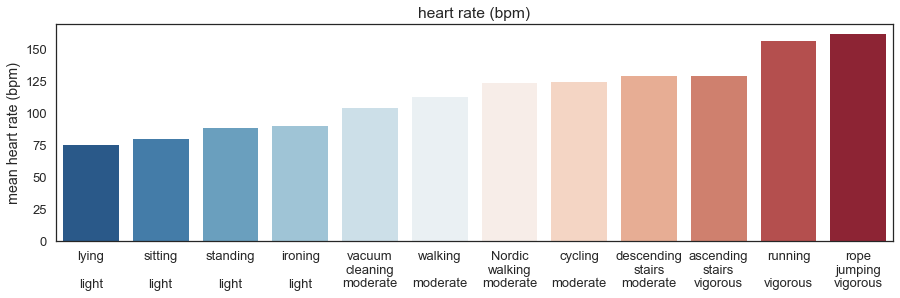

In [119]:
# get the mean heart rate for each activity 
activity_names, heart_rates = get_mean_attribute(df_train,'heart rate')
title = 'heart rate (bpm)'
y_title = 'mean ' + title
plot_attribute_of_activities(activity_names, heart_rates, y_title,title)

#### Observation
As shown in the figure above, activities that are consuming more energy and therefore belong to a higher MET class, have in average also a higher heart rate. 

### 3D-acceleration of the hand IMU

The plotted bar charts show the mean 3D-acceleration of all 3 IMUs for each activity. It has to be mentioned that a negative 3D-acceleration value does not mean that the subject is slowing down as it is known in physics. A positive or a negative value indicates which direction on the axis the subject moves.


In [120]:
%%javascript
// this javascript command increases the window size of the outputs 
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

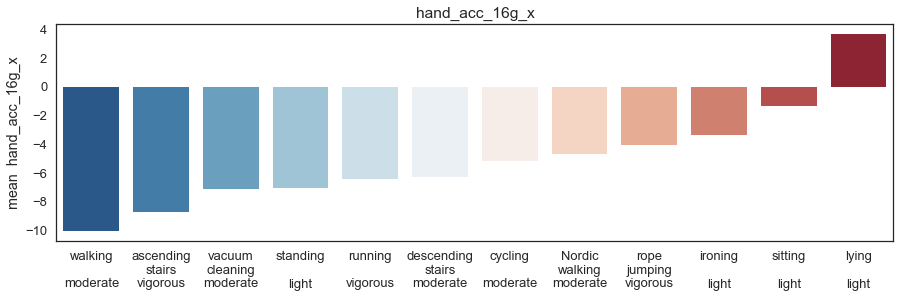

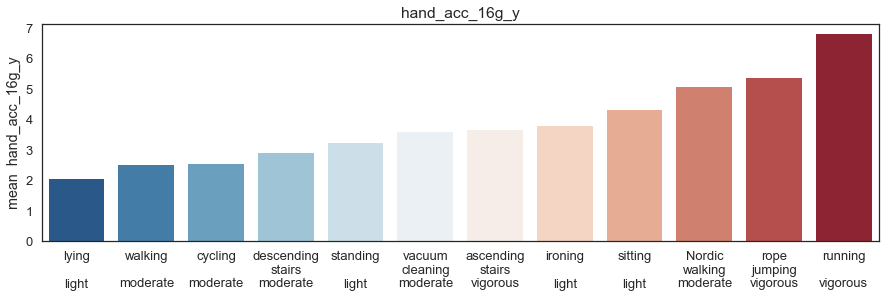

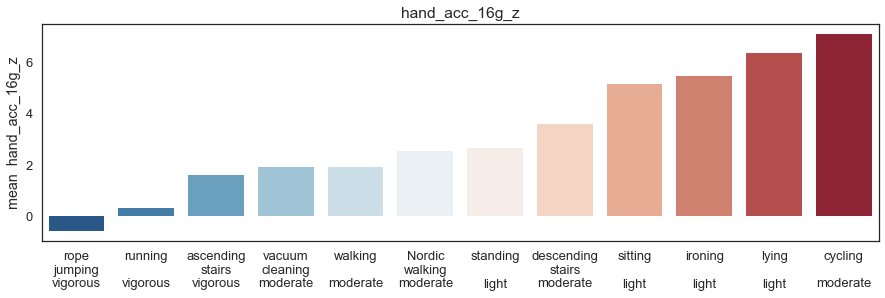

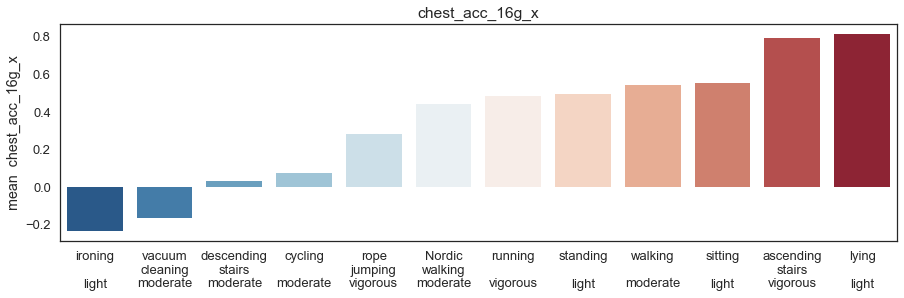

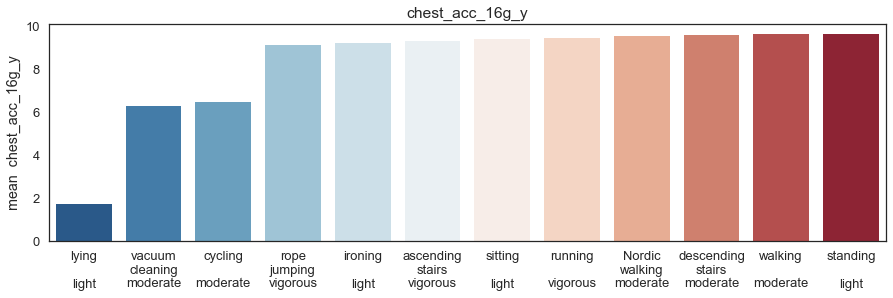

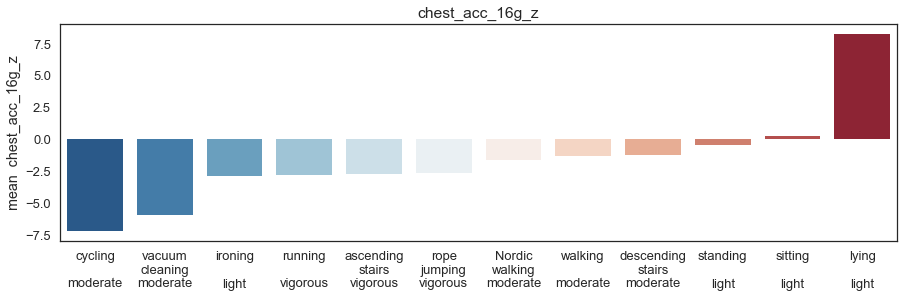

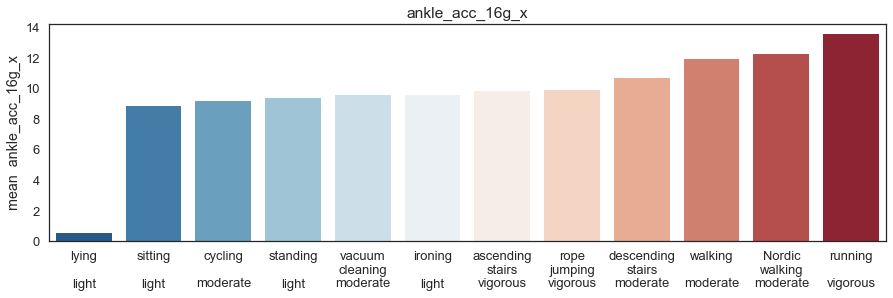

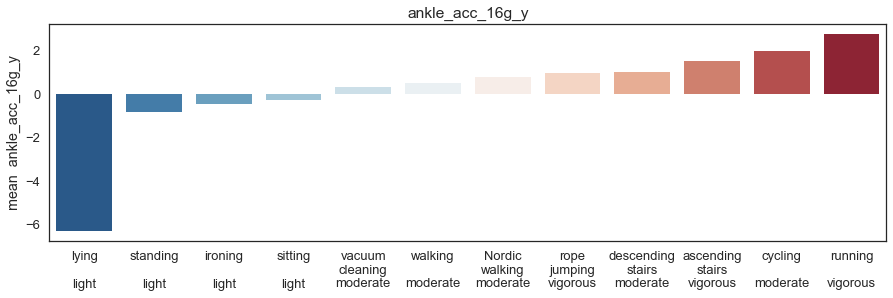

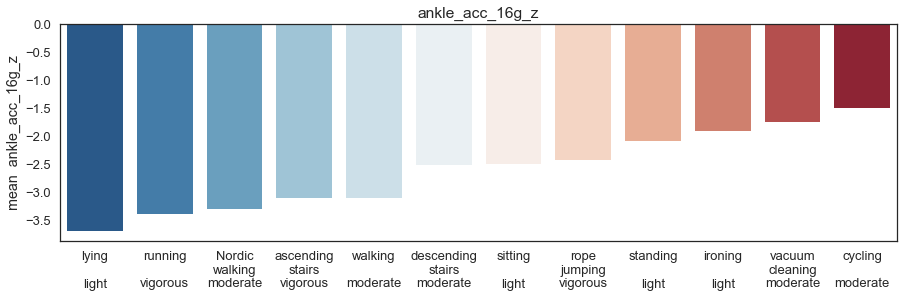

In [101]:
 # get the mean 3D-accelerations for each activity 
for i in range(1,len(feature_columns)):
    activity_names, hand_acc_16g_x = get_mean_attribute(df_train,feature_columns[i])
    title = feature_columns[i]
    y_title = 'mean  ' + title
    plot_attribute_of_activities(activity_names, hand_acc_16g_x,y_title,title)

### Observations
Most 3D-acceleration attributes from the IMUs follow some patterns while the relevance of the pattern depends on the classification problem. For the 'all activity recognition task' the values of the accelerations have to be distinguishable from each other which is mostly the case. Exceptions are the attributes chest_acc_y and ankle_acc_x since the activities measured by those accelerations are similar regarding the axis. For example, sitting and running have similar values for the chest y-acceleration since the chest is in a similar y-position while performing those activities.

For the 'intensity estimation task' the values within the MET classes have to be similar. The observations below are related to this classification problem.

#### hand x-acceleration: 
In average, light (light in respect to the light MET class) activities have a similar hand x-acceleration values. There is an exception with the activity 'standing' which is described as standing still in the description of the activities. However, it is also mentioned that gesticulating is possible while standing which explains the acceleration. 

#### hand y-acceleration
In average, vigorous activities have a similar hand y-acceleration values.

#### hand z-acceleration
In average, light activities have a similar hand z-acceleration values. 

#### chest x-acceleration
In average, moderate activities have similar chest x-acceleration values. 

#### chest y-acceleration 
There is no obvious pattern for this attribute regarding the 'intensity estimation task' nor for the 'all activity recognition task'. By not considered the mean of this attribute as a feature, some scores in the benchmark slightly decrease by 1% whereas the majority of the scores increase by 2% to 7%.  

#### chest z-acceleration
In average, vigorous activities have a similar chest z-acceleration values.

#### ankle x-acceleration
In average, moderate and vigorous activities have a similar ankle x-acceleration values. 

#### ankle y-acceleration
In average, light activity values are negative while the other activities positive 

#### ankle z-acceleration
There is no obvious pattern for the 'intensity estimation task' apparent. However, the ankle z-accelerations values are mostly distinguishable and hence its useful for the 'all activity recognition task'. This illustrates the problem of having different classifications problems. One attribute might irrelevant or even harmful (decreasing accuracy) for one classification while it can be relevant for another one. 

# 4. Hypothesis Testing 

## Hypothesis 1
The first hypothesis is based on the EDA of the heart rate. 

In [121]:
mean_heart_rate_light_met = df_test.query('activityID == [1,2,3,17]')['heart rate'].mean()
print('the mean heart rate of the activities from the light MET class:',round(mean_heart_rate_light_met),'bpm')

the mean heart rate of the activities from the light MET class: 84 bpm


### Null Hypothesis
- The mean heart rate of the activities from the moderate MET class is equals to the mean heart rate of the activities from the light MET class

### Alternative Hypothesis
- The mean heart rate of the activities from the moderate MET class is higher than the mean heart rate of the activities from the light MET class

<br>
$$h_0:\mu = 84$$
$$h_a:\mu > 84$$




### Z-score and p-value
The following formula is used to calculate the z-score and the corresponding p-value:

$$ z = \frac{X - \mu}{\frac{\sigma}{\sqrt{n}}}$$

In [122]:
n_heartrates_moderate_met, mean_heartrate_moderate_met, std_heartrate_moderate_met,z,pvalue = \
calculate_attribute_parameter('heart rate',mean_heart_rate_light_met)

print('X: mean heart rate of the activities from the moderate MET class =',round(mean_heartrate_moderate_met),'bpm')
print('mu: mean heart rate of the activities from the light MET class =',round(mean_heart_rate_light_met) ,'bpm')
print('sigma: std around the mean heartrate form the moderate MET class =',round(std_heartrate_moderate_met),'bpm')
print('n: number of samples =',n_heartrates_moderate_met)
print('z-score =',z)
print('p-value =',pvalue)

X: mean heart rate of the activities from the moderate MET class = 118 bpm
mu: mean heart rate of the activities from the light MET class = 84 bpm
sigma: std around the mean heartrate form the moderate MET class = 16 bpm
n: number of samples = 436320
z-score = 1432.47380777
p-value = 0.0


### Analysis 

The mean heart rate from the moderate MET class is with a value of 118 bpm significantly higher than the mean heart rate from the light MET class with a value of 84 bpm. This with the combination of a large number of samples causes the p-value to converges to zero and thus is rounded to zero by python. In conclusion, the heart rate plays a statistical significance for determining whether an activity belongs to the light or moderate MET class. 

## Hypothesis 2
For the second hypothesis the hand x-acceleration is chosen as a representative of the 3D-accelerations. 

In [125]:
mean_x_acc_hand_light_met = df_test.query('activityID == [1,2,3,17]')['hand_acc_16g_x'].mean()
print('mean hand x-acceleration of the light MET class:',"%.2f" % mean_x_acc_hand_light_met)

mean hand x-acceleration of the light MET class: -2.11


### Null Hypothesis
- The mean hand x-acceleration of the activities from the moderate MET class is equals to the mean hand x-acceleration  of the activities from the light MET class

### Alternative Hypothesis
- The mean hand x-acceleration of the activities from the moderate MET class is lower to the mean hand x-acceleration  of the activities from the light MET class

<br>
$$h_0:\mu = -2.11$$
$$h_a:\mu < -2.11$$

### Z-score and p-value

In [127]:
n_x_acc_hand_moderate_met, mean_x_acc_hand_moderate_met, std_x_acc_hand_moderate_met,z,pvalue = \
calculate_attribute_parameter('hand_acc_16g_x',mean_x_acc_hand_light_met)

print('X: mean hand x-acceleration of the moderate MET class =',"%.2f" % mean_x_acc_hand_moderate_met)
print('mu: mean hand x-acceleration of the light MET class =',"%.2f" %mean_x_acc_hand_light_met)
print('sigma: std around the mean hand x-acceleration of the moderate MET class = ' "%.2f" % std_x_acc_hand_moderate_met)
print('n: number of samples =',n_x_acc_hand_moderate_met)
print('z-score =',z)
print('p-value =', 1 - pvalue)

X: mean hand x-acceleration of the moderate MET class = -6.96
mu: mean hand x-acceleration of the light MET class = -2.11
sigma: std around the mean hand x-acceleration of the moderate MET class = 4.83
n: number of samples = 436320
z-score = -663.102532486
p-value = 0.0


### Analysis 
The mean hand x-acceleration from the moderate MET class is with a value of -6.96 significantly lower than the mean hand x-acceleration from the light MET class with a value of -2.11. Similar to the first hypothesis, a large number of samples causes the p-value to converges to zero and thus is rounded to zero by python. In conclusion, the x-acceleration and probably the other 3D-accelerations as well play a statistical significance for determining whether an activity belongs to the light or moderate MET class. 

# 5. Models 
In the next chapters different classifiers are trained and tested based on the knowledge gained from the data exploration and hypothesis testing. 

## Segmentation 

Sliding window is a method of time-series analysis and used for segmentation. The rows (time-series of 0.01s) are divided into a sequence of segments in order to extract the features. As stated by Reiss and Stricker (2012), a window length of about 3-5 seconds is reasonable because it allows to obtain at least 2 or 3 periods of all different movements. Thus, the following parameters are chosen:

- window size: 512 samples 
- shift size: 100 samples 

This results in 5.12 seconds as window size, shifted by 1 second between consecutive windows. The reason for the choice of 512 samples is to assure effective FFT (Fast Fourier transform) calculation as described in the paper. However, the features that could be obtained from the frequency domain are not of interest. Nevertheless, 512 samples are chosen for the window size for having a comparison to the benchmarks of Reiss and Stricker. 

In [128]:
class_window_mappings = sliding_window(classification_problem[1],df)

The sliding_window function returns a list of mappings between a window and its corresponding class. What kind of class it returns depends on the classification problem. In this case the 'all activity recognition task' has been chosen so that there are 12 different classes. 

## Feature Extraction 
The next step in the data processing pipeline is the extraction of the features. There are several possible features that can be extracted from the segmented 3D-acceleration data. Reiss and Stricker (2012) list the following ones, however, not all of them were used by them: 

- signal features in both time and frequency domain
- mean, median, standard deviation, peak acceleration and energy
- absolute integral
- Correlation between each pair of axes
- Spectral entropy of the normalized PSD (spectral density)
- From the heart rate data, the mean and gradient

They extracted in total 137 features from each data window (133 features from IMU acceleration data and 4 features from the heart rate). No reduction of the feature space was applied on the feature set. 

### Selected features
Some of the above listed features are useful for the two mentioned classification problems that are not considered in this assignment. The results during the EDA encourage to use the mean as a feature and thus the wide range of possible features is reduced to:  

- the mean of each axes of the 3D-acceleration data for each IMU except the mean chest y-acceleration since it has no relevant pattern for the defined classification problems (8 features)
- the mean of the heart rate (1 feature)

This results in 9 features which are extracted from each window.  

#### feature_extraction function 
The sliding window method returns 19434 windows and their corresponding classes. This is given the feature_extraction function as input and respectively 19434 feature vectors are obtained, each containing 9 features, as well 19434 targets. The term target is more common in machine learning and is interchangeably used with the term class.

The mapping between the two lists mean_features and the targets is free since both have the same order. For example, the mean_feature at index 100 belongs to target at index 100.  

In [129]:
mean_features, targets = feature_extraction(class_window_mappings)

In [130]:
print('number of feature vectors:',len(mean_features))
print('number of targets',len(targets))

number of feature vectors: 19434
number of targets 19434


## Classifiers 

Using a data processing chain enables to use the extracted features as input to test several classifier. Reiss and Stricker (2012) applied five classifiers for creating the benchmarks:

- Decision tree (C4.5)
- Boosted decision tree (C4.5)
- Bagging decision tree (C4.5)
- Naive Bayes
- k-nearest neighbors (k-NN)

For a having a comparison to the current benchmarks, the same classifiers are applied. The standard decision tree is chosen as a representative for the different versions. Supplementary, the support vector machine (SVM)is introduced as a new classifier.

###  The naive bayes classifier
The naive Bayes method is a supervised learning algorithm based on the Bayes’ theorem. It has the 'naive' assumption that features are independent from each other. The scikit-learn library provides various implementations such as the chosen GaussianNB method which assumes that the likelihood of the features is Gaussian. 

### The decision tree classifier
Decision trees are supervised learning methods that can used for classification. The classifier predicts the value of a target by learning simple decision rules inferred from the data features. Unlike the C4.5 decision tree algorithm used by Reiss and Stricker, the scikit-learn uses the CART version which is very similar to C4.5 but does not compute rule sets. CART constructs binary trees by using the feature and threshold that provide the largest information gain at each node.

### The k-nearest neighbors classifier
The principle behind nearest neighbor method is to classify a feature to the class which is the most common among its k-nearest neighbors. The scikit-learn library has k=5 (number of neighbors) per default while Reiss and Stricker (2012) suggest k=7 for the classification. 

### The support vector machines classifier 
SVM can be used for classification problems with two classes. It maps each feature as a point in a n-dimensional space (where n is number of features). Subsequently, hyperplanes are defined to differentiate the two classes. However, scikit-learn supports n classes by constructing n * (n - 1) / 2 classifiers and each one is trained from two classes. 

### Train and test set 
For calculating the accuracy of the classifiers both the feature and the target vectors are randomly divided into train and test sets with 7:3 as a ratio. The train_test_split() function of scikit-learn is used which is capable of keeping the order between the features and their corresponding targets correctly. 

In [131]:
features_train, features_test, target_train, target_test = split_train_test(mean_features,targets) 

### Scikit-learn classifiers functions  
For every scikit-learn classifier the same two functions are called: 
- fit(X, y): The classifier is trained with the train set by calling the fit function which takes two parameters. The first one is a matrix, a list of feature vectors and thus represented with a capital X in the documentation. The second parameter is a vector which contains the values of corresponding target.
- predict(X): The predict function takes the feature test set as parameter, the unseen data. It returns a list of the predicted targets. 

# 6. Results 

The results are presented in four different score metrics which are explained in more detail.  

The scikit-learn score functions take two parameters, the actual target (target_test) and the predicted target as returned by a classifier. The combination of those two targets can create 4 different scenarios. This is illustrated in the following example where siting is referred as positive and walking (not siting) as negative. 

- True Positive (TP): actual target positive and predicted target positive. For example, the subject was siting and siting was predicted.
- True Negative (TN): actual target negative and predicted target negative. For example, the subject was walking and walking was predicted. 
- False Positive (FP): actual target negative and predicted target positive. For example, the subject was walking but siting was predicted.
- False Negative (FN): actual target positive and predicted target negative. For example, the subject was siting but walking was predicted. 

Having defined the different combinations, the following four common metrics are taken into account for calculating the score. 

#### Accuracy 
Ratio of correctly predicted targets to the total targets:
- Accuracy = TP + TN / TP + FP + FN + TN

#### Precision
Ratio of correctly predicted positive targets to the total predicted positive targets.
- Precision = TP / TP + FP

#### Recall 
Ratio of correctly predicted positive targets to the total of all actual positive targets. 
- Recall = TP / TP + FN

#### F-measure 
Weighted average of Precision and Recall.
- F-measure = 2 \* (Recall * Precision) / (Recall + Precision)

## Scores 
The tables above summarise the achieved scores of the 4 classifiers. For each classification problem, the current benchmark performed by Reiss and Stricker (2012) is given as point of reference. For simplicity, precision, recall, F-measure and accuracy are called PRFA.  

### Classification problem 1 - All activity recognition task

#### Current Benchmark

In [132]:
get_current_scores(classification_problem[1])

,Precision,Recall,F-measure,Accuracy
Naive Bayes,0.9419,0.9519,0.9469,0.9438
Decision Tree,0.9554,0.9563,0.9558,0.9546
kNN,0.9946,0.9937,0.9942,0.9925


#### New Scores 

In [133]:
get_scores_from_all_clf(features_train,target_train,features_test)

,Precision,Recall,F-measure,Accuracy
Naive Bayes,0.8323,0.8169,0.8205,0.8283
Decision Tree,0.9288,0.9249,0.9267,0.9311
kNN,0.9535,0.9408,0.9464,0.9523
SVM,0.9691,0.9607,0.9644,0.9683


#### Observations  
All classifiers score lower in PRFA than in the current benchmarks:
- Naive Bayes around 10% to 14%
- Decision Tree around 2 to 3%%  
- kNN around 4% to 5% 

SVM has with an average of 96% in PRFA the highest score compared other new scores while kNN is with with an average of 95% close behind. 

### Classification problem 2 - Intensity estimation task

#### Current Benchmark 

In [134]:
get_current_scores(classification_problem[2])

,Precision,Recall,F-measure,Accuracy
Naive Bayes,0.9157,0.8553,0.8845,0.9310
Decision Tree,0.9796,0.9783,0.9789,0.9823
kNN,0.9985,0.9987,0.9986,0.9982


#### New Benchmark 

In [144]:
# the data process chain is reapeated for the intensity estimation task
class_window_mappings = sliding_window(classification_problem[2],df)
mean_features, target_classes = feature_extraction(class_window_mappings)
features_train, features_test, target_train, target_test = split_train_test(mean_features,target_classes) 
get_scores_from_all_clf(features_train,target_train,features_test)

,Precision,Recall,F-measure,Accuracy
Naive Bayes,0.8055,0.7502,0.7630,0.7829
Decision Tree,0.9588,0.9579,0.9584,0.9654
kNN,0.9769,0.9666,0.9715,0.9768
SVM,0.9852,0.9757,0.9803,0.9849


#### Observations 
All classifiers score lower in PRFA than in the current benchmarks:
- Naive Bayes scores around 10% to 15% 
- Decision Tree scores around 2% to 3% 
- kNN scores around 1% to 2%

The results are similar to the first benchmark comparison, the SVM has with an average of 98% in PRFA the highest score compared other new scores while kNN has an average of 97%. 

## Benchmark Analysis 

Ideally, using the same classifiers should result in the same benchmark scores, however, all the classifiers perform worse. One reason is the number of features used to train the models. Reis and Stickers used 137 features whereas only 9 features were used to train the new classifiers. Nevertheless, the overall performance of the classifiers is good. While the Naive Bayes performance is satisfactory, the other classifiers have at least a PRFA score of 93%. Especially kNN and the newly introduced classifier SVM perform well in both classification problems where SVM has an average PRFA of 98% for the 'intensity estimation task'. The relative high scores with only 9 features could be explained with the bias-variance trade-off. By having 9 instead of 137 features, the classifiers have a higher bias and produce simpler models that are underfitting the training set and therefore failing to capture important patterns. This is not a problem in the defined framework of this project since two classifications problems are used instead of four as in the case of Reis and Stickers. On the other hand, having a higher bias allows to have a lower variance so that unseen patterns can be generalized better.    


### Further research 
- It would be of interest to measure the performance of the classifiers if there are trained with more features such as std, median or the correlation between each pair of axes. There might be a possibility that SVM outperforms all the scores in the current benchmark if it is trained with the 137 features used by Reiss and Stickers. 

- The optional files contain different activities than in the subject files. One way to take advantage of those files is by training the classifiers with the subjects files regarding the 'intensity estimation problem' and use the optional files to predict the MET classes of the optional activities.  


# 7. Duration prediction
The goal of the assignment is not only to identify the type of an activity but also the amount carried out by an subject. The following parameters are chosen in the example:
- The dataset of the 9 subjects. 
- The  classification problem 'all activity recognition task'.
- The classifier SVM trained with 70% train and 30% test set.

The predicted and expected amount of an activity are determined by counting the number of values from the predicted target and test target. Knowing that every target value corresponds to a window size of 1s, the sum of the len of the targets results in the amount of an activity.   

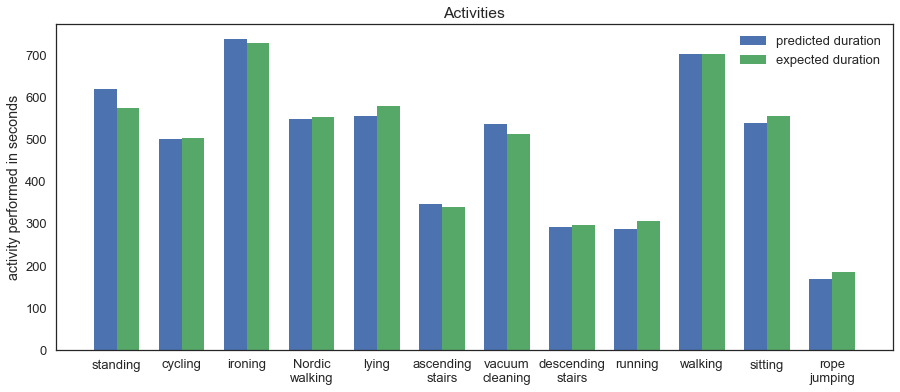

In [136]:
# the data process chain is reapeated for the all activity recognition task using the svm classifier 
class_window_mappings = sliding_window(classification_problem[1],df)
mean_features, targets = feature_extraction(class_window_mappings)
features_train, features_test, target_train, target_test = split_train_test(mean_features,targets) 
target_pred = apply_svm_clf(features_train, target_train, features_test)

# counts the durations of an activity based on the target prediciton and the ground truth
activity_names, predicted_durations = count_activity_amount(target_pred)
activity_names, expected_durations = count_activity_amount(target_test)

# plots two bar charts in one figure, the exptected and predicted durations  
plot_activity_bar(activity_names,predicted_durations,expected_durations)

As shown in the figure above, there might be a slight difference between the predicted and expected durations which is caused by the 4% error rate of the SVM classifier. 

# 8. Conclusion

The amount and type of the activities could be successfully determined. This was achieved by first cleaning the dataset and handle missing values using interpolation. During the next step, the data was explored in order to get insights from the data. It revealed that the mean of the heart rate and the mean of the 3D-accelerations data from the IMUs are reliable indicators for the type of an activity. It also showed that the mean of the chest y-acceleration has no benefits regarding both classification problems. The hypothesis testing proved that there is an statistical significance for the mean assumption. Knowing that, the means of those attributes were extracted as features by dividing the data into a sequence of segments with a window size of 5.12s and a shift size of 1s. Eventually, the features were used to train and test four different classifiers. The three classfiers naive Bayes, decision tree and k-nearest neighbors were compared to the current benchmark. The new scores were varying between 78% to 98% in PRFA and were in average lower than in the current benchmark. The support vector machine, which was introduced as a new classifier, achieved the highest result with an score of 96% for the 'all activity recognition task' and 98% for the 'intensity estimation task'. This makes the SVM an interesting candidate for further research. 
In conclusion, the PAMAP2 dataset with its various activities carried out by different subject provides an excellent environment for data exploration, hypothesis testing and supervised machine learning.  




# 9. Bibliography 
A. Reiss and D. Stricker (2012). Creating and Benchmarking a New Dataset for Physical Activity Monitoring. The 5th Workshop on Affect and Behaviour Related Assistance (ABRA).